## Facebook Prophet

# Objective
The objective of this project is to forecast the short-term closing price of NVIDIA (NVDA) stock using classical time-series models and compare their performance using information criteria and forecast accuracy.

In [7]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

import seaborn as sns
import os
import time

In [8]:
TICKERS = ['NVDA', 'SPY', 'AAPL']
START_DATE = '2021-01-01'
END_DATE = '2026-02-05'

stocks = yf.download(
    TICKERS,
    start=START_DATE,
    end=END_DATE,
    group_by='ticker',
    auto_adjust=True,
    prepost=True,
    threads=True,
    progress=False

)
stocks

Ticker            AAPL                                                 \
Price             Open        High         Low       Close     Volume   
Date                                                                    
2021-01-04  129.975362  130.062969  123.394822  125.974472  143301900   
2021-01-05  125.468246  128.242590  125.020451  127.531960   97664900   
2021-01-06  124.329329  127.570927  123.024899  123.239059  155088000   
2021-01-07  124.952376  128.135570  124.465650  127.444412  109578200   
2021-01-08  128.914320  129.109023  126.772727  128.544418  105158200   
...                ...         ...         ...         ...        ...   
2026-01-29  258.000000  259.649994  254.410004  258.279999   67253000   
2026-01-30  255.169998  261.899994  252.179993  259.480011   92443400   
2026-02-02  260.029999  270.489990  259.209991  270.010010   73913400   
2026-02-03  269.200012  271.880005  267.609985  269.480011   64394700   
2026-02-04  272.290009  278.950012  272.290009  276.489990   90545700   

Ticker             SPY                                                 \
Price             Open        High         Low       Close     Volume   
Date                                                                    
2021-01-04  350.342969  350.473669  340.550812  344.256714  110210800   
2021-01-05  343.612576  347.719865  343.565885  346.627686   66426200   
2021-01-06  345.115558  351.901950  344.564810  348.700104  107997700   
2021-01-07  351.080431  354.627629  350.903068  353.880859   68766800   
2021-01-08  355.271775  356.111898  352.013952  355.897217   71677200   
...                ...         ...         ...         ...        ...   
2026-01-29  696.390015  697.059998  684.830017  694.039978   97486200   
2026-01-30  691.789978  694.210022  687.119995  691.969971  101835100   
2026-02-02  689.580017  696.929993  689.419983  695.409973   79286500   
2026-02-03  696.210022  696.960022  684.030029  689.530029  107904600   
2026-02-04  690.349976  691.450012  681.760010  686.190002  105204600   

Ticker            NVDA                                                 
Price             Open        High         Low       Close     Volume  
Date                                                                   
2021-01-04   13.067502   13.614215   12.926149   13.076726  560640000  
2021-01-05   13.063015   13.405801   13.050301   13.367160  322760000  
2021-01-06   13.185421   13.207858   12.550707   12.579126  580424000  
2021-01-07   12.931133   13.340234   12.850361   13.306578  461480000  
2021-01-08   13.325027   13.383363   13.005426   13.239517  292528000  
...                ...         ...         ...         ...        ...  
2026-01-29  191.339996  193.479996  186.059998  192.509995  171764400  
2026-01-30  191.210007  194.490005  189.470001  191.130005  179489500  
2026-02-02  187.199997  190.300003  184.880005  185.610001  165794100  
2026-02-03  186.240005  186.270004  176.229996  180.339996  204019600  
2026-02-04  179.460007  179.580002  171.910004  174.190002  207014100  

[1278 rows x 15 columns]

In [9]:
stocks.columns

MultiIndex([('AAPL',   'Open'),
            ('AAPL',   'High'),
            ('AAPL',    'Low'),
            ('AAPL',  'Close'),
            ('AAPL', 'Volume'),
            ( 'SPY',   'Open'),
            ( 'SPY',   'High'),
            ( 'SPY',    'Low'),
            ( 'SPY',  'Close'),
            ( 'SPY', 'Volume'),
            ('NVDA',   'Open'),
            ('NVDA',   'High'),
            ('NVDA',    'Low'),
            ('NVDA',  'Close'),
            ('NVDA', 'Volume')],
           names=['Ticker', 'Price'])

In [10]:
stocks.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1278 entries, 2021-01-04 to 2026-02-04
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (AAPL, Open)    1278 non-null   float64
 1   (AAPL, High)    1278 non-null   float64
 2   (AAPL, Low)     1278 non-null   float64
 3   (AAPL, Close)   1278 non-null   float64
 4   (AAPL, Volume)  1278 non-null   int64  
 5   (SPY, Open)     1278 non-null   float64
 6   (SPY, High)     1278 non-null   float64
 7   (SPY, Low)      1278 non-null   float64
 8   (SPY, Close)    1278 non-null   float64
 9   (SPY, Volume)   1278 non-null   int64  
 10  (NVDA, Open)    1278 non-null   float64
 11  (NVDA, High)    1278 non-null   float64
 12  (NVDA, Low)     1278 non-null   float64
 13  (NVDA, Close)   1278 non-null   float64
 14  (NVDA, Volume)  1278 non-null   int64  
dtypes: float64(12), int64(3)
memory usage: 159.8 KB


### The result shows the DataFrame has 2023 entries and 15 columns with no null values.

In [11]:
stocks.describe()

Ticker         AAPL                                                       \
Price          Open         High          Low        Close        Volume   
count   1278.000000  1278.000000  1278.000000  1278.000000  1.278000e+03   
mean     180.803343   182.764853   179.020228   180.980631  6.955189e+07   
std       41.095204    41.390629    40.838258    41.141424  2.983656e+07   
min      116.043185   117.378796   113.293918   113.440155  1.791060e+07   
25%      146.084922   147.988804   144.884867   146.439369  4.820820e+07   
50%      172.056255   174.155493   171.034074   172.122406  6.262950e+07   
75%      212.170786   214.495443   210.163782   212.640003  8.424670e+07   
max      286.200012   288.619995   283.299988   286.190002  3.186799e+08   

Ticker          SPY                                                       \
Price          Open         High          Low        Close        Volume   
count   1278.000000  1278.000000  1278.000000  1278.000000  1.278000e+03   
mean     473.766213   476.364854   470.925381   473.865181  7.616250e+07   
std       98.869751    98.894862    98.662052    98.820964  2.922574e+07   
min      334.149103   344.301478   333.096538   341.182068  2.604870e+07   
25%      393.922090   396.136935   392.266505   394.242157  5.689705e+07   
50%      433.573979   434.528783   430.446049   432.456070  7.151200e+07   
75%      554.245940   558.480156   550.618764   554.399643  8.974358e+07   
max      697.049988   697.840027   693.940002   695.489990  2.566114e+08   

Ticker         NVDA                                                       
Price          Open         High          Low        Close        Volume  
count   1278.000000  1278.000000  1278.000000  1278.000000  1.278000e+03  
mean      69.356255    70.504904    68.054208    69.329726  3.907986e+08  
std       59.205625    59.987652    58.200129    59.103824  1.843901e+08  
min       10.957225    11.720264    10.799423    11.212904  6.552850e+07  
25%       19.451996    19.817180    19.049821    19.515130  2.365302e+08  
50%       42.366420    43.164100    41.713873    42.327450  3.756440e+08  
75%      121.724508   124.009573   118.226890   121.585546  5.028558e+08  
max      208.068415   212.178195   205.548551   207.028473  1.543911e+09

In [12]:
type(stocks)

pandas.core.frame.DataFrame

In [13]:
# Divide the stocks DataFrame by TICKER and duplicate it.
nvda = stocks['NVDA'].copy()
spy = stocks['SPY'].copy()
aapl = stocks['AAPL'].copy()

# All indices are sorted chronologically to preserve temporal order.
nvda = nvda.sort_index()
spy = spy.sort_index()
aapl = aapl.sort_index()

## Define the prediction task

This project focuses on classical time-series forecasting methods demonstrated in class, comparing ARIMA, Prophet, and linear trend models using AIC and forecast error metrics.

In [14]:
# Predict whether NVDA’s 5-day return exceeds a minimum meaningful threshold.

# threshold = 0.01 #(1%)

# nvda['future_return_5d'] = nvda['Close'].pct_change(5).shift(-5)
# nvda['target'] = (nvda['future_return_5d'] > threshold).astype(int)
# nvda

# nvda['target'].value_counts(normalize=True)

In [15]:
nvda.head()
nvda.tail()

Price,Open,High,Low,Close,Volume
Date,,,,,
2026-01-29,191.339996,193.479996,186.059998,192.509995,171764400
2026-01-30,191.210007,194.490005,189.470001,191.130005,179489500
2026-02-02,187.199997,190.300003,184.880005,185.610001,165794100
2026-02-03,186.240005,186.270004,176.229996,180.339996,204019600
2026-02-04,179.460007,179.580002,171.910004,174.190002,207014100


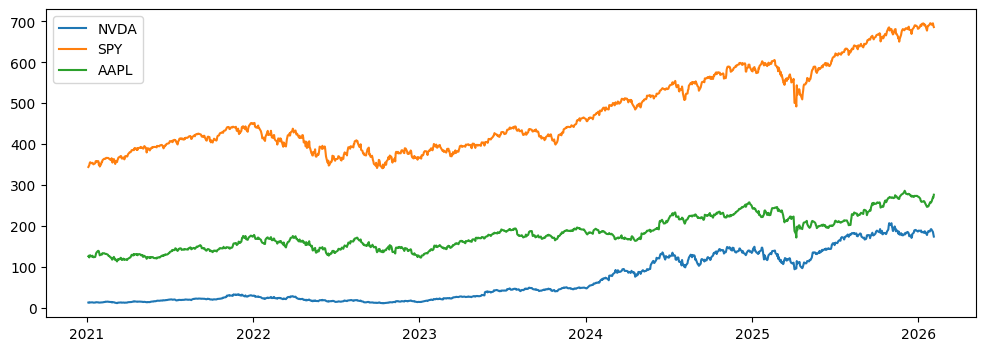

In [16]:
plt.figure(figsize=(12, 4))
plt.plot(nvda.index, nvda['Close'], label='NVDA')
plt.plot(spy.index, spy['Close'], label='SPY')
plt.plot(aapl.index, aapl['Close'], label='AAPL')
plt.legend()

plt.show()

In [17]:
type(stocks)

pandas.core.frame.DataFrame

In [18]:
# Divide the stocks DataFrame by TICKER and duplicate it.
nvda = stocks['NVDA'].copy()
spy = stocks['SPY'].copy()
aapl = stocks['AAPL'].copy()

# All indices are sorted chronologically to preserve temporal order.
nvda = nvda.sort_index()
spy = spy.sort_index()
aapl = aapl.sort_index()

In [19]:
# Predict whether NVDA’s 5-day return exceeds a minimum meaningful threshold.

# threshold = 0.01 #(1%)

# nvda['future_return_5d'] = nvda['Close'].pct_change(5).shift(-5)
# nvda['target'] = (nvda['future_return_5d'] > threshold).astype(int)
# nvda

# nvda['target'].value_counts(normalize=True)

In [20]:
nvda.head()
nvda.tail()

Price,Open,High,Low,Close,Volume
Date,,,,,
2026-01-29,191.339996,193.479996,186.059998,192.509995,171764400
2026-01-30,191.210007,194.490005,189.470001,191.130005,179489500
2026-02-02,187.199997,190.300003,184.880005,185.610001,165794100
2026-02-03,186.240005,186.270004,176.229996,180.339996,204019600
2026-02-04,179.460007,179.580002,171.910004,174.190002,207014100


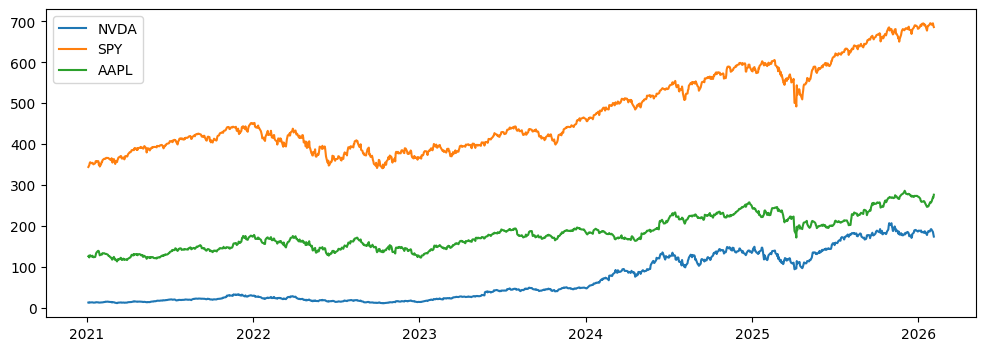

In [21]:
plt.figure(figsize=(12, 4))
plt.plot(nvda.index, nvda['Close'], label='NVDA')
plt.plot(spy.index, spy['Close'], label='SPY')
plt.plot(aapl.index, aapl['Close'], label='AAPL')
plt.legend()

plt.show()


The chart indicates that all three stocks (NVDA, SPY, AAPL) have a non-stationary series. NVDA's trend has minor incline but rose sharply starting from 2024. Even with minor drop in early 2025, the stock price seems to be going upward.

In [22]:
# Create Prophet dataset
prophet_nvda = nvda['Close'].reset_index()
prophet_nvda.columns = ['ds', 'y']
prophet_train = prophet_nvda.iloc[:-90]
prophet_test  = prophet_nvda.iloc[-90:]

prophet_nvda.head(10)

,ds,y
0,2021-01-04,13.076726
1,2021-01-05,13.367160
2,2021-01-06,12.579126
3,2021-01-07,13.306578
4,2021-01-08,13.239517
5,2021-01-11,13.583302
6,2021-01-12,13.446933
7,2021-01-13,13.493800
8,2021-01-14,13.163233
9,2021-01-15,12.823441


------------------
# Facebook Prophet

In [25]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

### Initialize the Prophet model
Prophet already includes: trend and atomatic changepoints

* Stock prices don't have meaningful daily/weekly seasonality.
* Yearly effects sometimes show up in tax cycles and earning cadence

In [27]:
# Traing
prophet_model = Prophet(yearly_seasonality=True,
                        weekly_seasonality=False,
                        daily_seasonality=False)

prophet_model.fit(prophet_train)

# prophet_model.fit(prophet_nvda)

### Transform the dataset to Facebook Prophet required format.

In [28]:
# Create future dates
prophet_future = prophet_model.make_future_dataframe(periods=120, freq='B') #'B' for business days. 120 days == 90 test days + 30 future days

# Predict and generate forecast
prophet_forecast = prophet_model.predict(prophet_future) # Generate

  # forecast contains:
  # trend
  # yearly seasonality
  # forecast (yhat)
  # confidence intervals (yhat_lower, yhat_upper)

# prophet_prophet_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

display(prophet_forecast.tail())
print()
display(prophet_forecast.head())

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1303,2026-03-06,177.991383,158.641898,184.911209,169.520303,186.019980,-5.935417,-5.935417,-5.935417,-5.935417,-5.935417,-5.935417,0.0,0.0,0.0,172.055966
1304,2026-03-09,178.316519,158.021509,185.140278,169.731133,186.392915,-6.223614,-6.223614,-6.223614,-6.223614,-6.223614,-6.223614,0.0,0.0,0.0,172.092904
1305,2026-03-10,178.424897,158.858851,185.378589,169.727650,186.536732,-6.264941,-6.264941,-6.264941,-6.264941,-6.264941,-6.264941,0.0,0.0,0.0,172.159957
1306,2026-03-11,178.533276,158.737539,184.816250,169.719280,186.706643,-6.280705,-6.280705,-6.280705,-6.280705,-6.280705,-6.280705,0.0,0.0,0.0,172.252571
1307,2026-03-12,178.641654,158.889836,186.058416,169.719586,186.866789,-6.273157,-6.273157,-6.273157,-6.273157,-6.273157,-6.273157,0.0,0.0,0.0,172.368497


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-01-04,17.990576,6.580721,26.785611,17.990576,17.990576,-1.366100,-1.366100,-1.366100,-1.366100,-1.366100,-1.366100,0.0,0.0,0.0,16.624476
1,2021-01-05,17.994580,5.823081,26.693555,17.994580,17.994580,-1.414313,-1.414313,-1.414313,-1.414313,-1.414313,-1.414313,0.0,0.0,0.0,16.580267
2,2021-01-06,17.998584,6.364641,26.899375,17.998584,17.998584,-1.478419,-1.478419,-1.478419,-1.478419,-1.478419,-1.478419,0.0,0.0,0.0,16.520164
3,2021-01-07,18.002587,6.170490,26.576306,18.002587,18.002587,-1.559858,-1.559858,-1.559858,-1.559858,-1.559858,-1.559858,0.0,0.0,0.0,16.442729
4,2021-01-08,18.006591,6.434871,26.458542,18.006591,18.006591,-1.659541,-1.659541,-1.659541,-1.659541,-1.659541,-1.659541,0.0,0.0,0.0,16.347050


In [29]:
prophet_eval = prophet_nvda.merge(
    prophet_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']],
    on='ds',
    how='left',
)

In [30]:
prophet_train_eval = prophet_eval.iloc[:-90]
prophet_test_eval  = prophet_eval.iloc[-90:]

In [31]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def mape(actual, pred):
    return np.mean(np.abs((actual - pred) / actual)) * 100

mae_train = mean_absolute_error(prophet_train_eval['y'], prophet_train_eval['yhat'])
mae_test = mean_absolute_error(prophet_test_eval['y'], prophet_test_eval['yhat'])

rmse_train = np.sqrt(mean_squared_error(prophet_train_eval['y'], prophet_train_eval['yhat']))
rmse_test = np.sqrt(mean_squared_error(prophet_test_eval['y'], prophet_test_eval['yhat']))

mape_train = mape(prophet_train_eval['y'], prophet_train_eval['yhat'])
mape_test = mape(prophet_test_eval['y'], prophet_test_eval['yhat'])

mae = mean_absolute_error(prophet_eval['y'], prophet_eval['yhat'])
rmse = np.sqrt(mean_squared_error(prophet_eval['y'], prophet_eval['yhat']))


print("===== PROPHET PERFORMANCE =====")
print(f"TRAIN  → MAE:  {mae_train:.2f}")
print(f"TRAIN  → RMSE: {rmse_train:.2f}")
print(f"TRAIN  → MAPE: {mape_train:.2f}%\n")

print(f"TEST   → MAE:  {mae_test:.2f}")
print(f"TEST   → RMSE: {rmse_test:.2f}")
print(f"TEST   → MAPE: {mape_test:.2f}%")

===== PROPHET PERFORMANCE =====
TRAIN  → MAE:  5.80
TRAIN  → RMSE: 8.07
TRAIN  → MAPE: 13.29%

TEST   → MAE:  16.69
TEST   → RMSE: 18.19
TEST   → MAPE: 8.86%


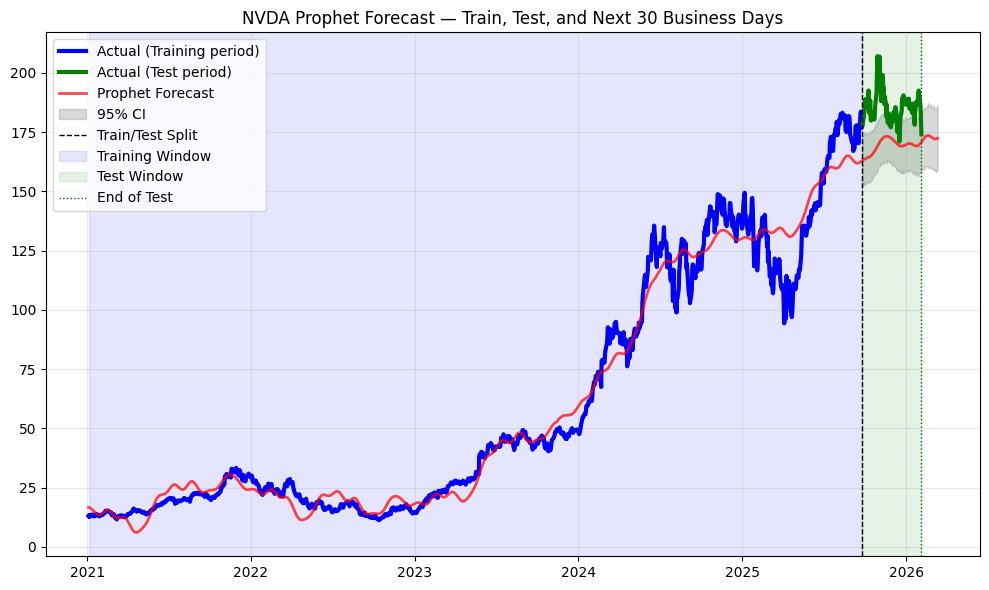

Test window start: 2025-09-26 00:00:00
Test window end:   2026-02-04 00:00:00
Forecast end:      2026-03-12 00:00:00


In [34]:
# Blue and green lines show actual NVDA prices; red line shows Prophet’s predictions.
plt.figure(figsize=(10,6))

# Actual data
plt.plot(prophet_train['ds'], prophet_train['y'],
         label='Actual (Training period)', linewidth=3, color='blue')

plt.plot(prophet_test['ds'], prophet_test['y'],
         label='Actual (Test period)', linewidth=3, color='green')

# Forecast
plt.plot(prophet_forecast['ds'], prophet_forecast['yhat'],
         label='Prophet Forecast', color='red', linewidth=2, alpha=0.7)

# Only shade future uncertainty
split_date = prophet_train['ds'].max()

forecast_future = prophet_forecast[
    prophet_forecast['ds'] > split_date
]

plt.fill_between(
    forecast_future['ds'],
    forecast_future['yhat_lower'],
    forecast_future['yhat_upper'],
    color='gray',
    alpha=0.3,
    label='95% CI'
)

# Train/Test split line
plt.axvline(
    x=split_date,
    color='black',
    linestyle='--',
    linewidth=1,
    label='Train/Test Split'
)

plt.title('NVDA Prophet Forecast — Train, Test, and Next 30 Business Days')



plt.axvspan(
    prophet_train['ds'].min(),
    prophet_train['ds'].max(),
    color='blue',
    alpha=0.10,
    label='Training Window'
)

plt.axvspan(
    prophet_train['ds'].max(),
    prophet_test['ds'].max(),
    color='green',
    alpha=0.10,
    label='Test Window'
)

plt.axvline(
    x=prophet_test['ds'].max(),
    color='darkgreen',
    linestyle=':',
    linewidth=1,
    label='End of Test'
)

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


print("Test window start:", prophet_test['ds'].min())
print("Test window end:  ", prophet_test['ds'].max())
print("Forecast end:     ", prophet_forecast['ds'].max())

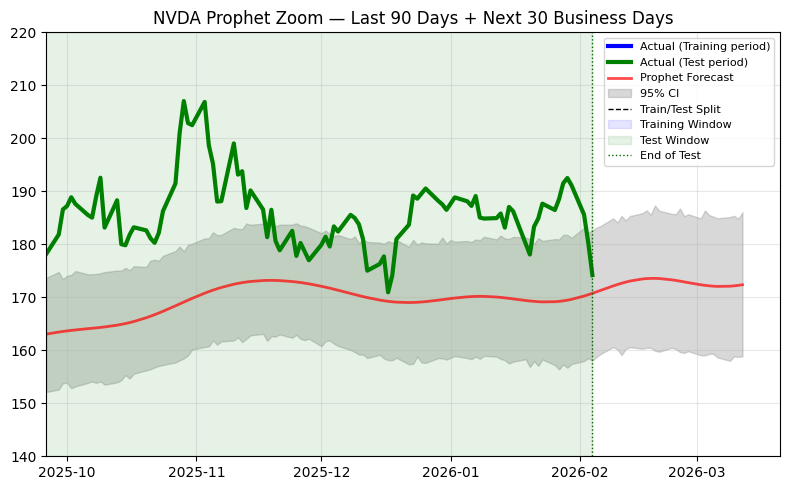

Test window start: 2025-09-26 00:00:00
Test window end:   2026-02-04 00:00:00
Forecast end:      2026-03-12 00:00:00


In [35]:
# correct v

plt.figure(figsize=(8,5))

# ---------- KEEP ALL YOUR ORIGINAL LAYERS ----------

plt.plot(prophet_train['ds'], prophet_train['y'],
         label='Actual (Training period)', linewidth=3, color='blue')

plt.plot(prophet_test['ds'], prophet_test['y'],
         label='Actual (Test period)', linewidth=3, color='green')

plt.plot(prophet_forecast['ds'], prophet_forecast['yhat'],
         label='Prophet Forecast', color='red', linewidth=2, alpha=0.7)

split_date = prophet_train['ds'].max()
test_start = prophet_test['ds'].min()
test_end = prophet_test['ds'].max()

forecast_future = prophet_forecast[
    prophet_forecast['ds'] > split_date
]

plt.fill_between(
    forecast_future['ds'],
    forecast_future['yhat_lower'],
    forecast_future['yhat_upper'],
    color='gray',
    alpha=0.3,
    label='95% CI'
)

plt.axvline(
    x=split_date,
    color='black',
    linestyle='--',
    linewidth=1,
    label='Train/Test Split'
)

plt.axvspan(
    prophet_train['ds'].min(),
    prophet_train['ds'].max(),
    color='blue',
    alpha=0.10,
    label='Training Window'
)

plt.axvspan(
    prophet_train['ds'].max(),
    prophet_test['ds'].max(),
    color='green',
    alpha=0.10,
    label='Test Window'
)

plt.axvline(
    x=test_end,
    color='darkgreen',
    linestyle=':',
    linewidth=1,
    label='End of Test'
)

# ---------- THIS IS THE ZOOM ----------

zoom_start = test_start # first day of the 90 day
zoom_end   = test_end + pd.Timedelta(days=45)   # a little room for the forecast

hist_zoom = prophet_nvda[prophet_nvda['ds'] >= test_start]
forecast_zoom = prophet_forecast[prophet_forecast['ds'] >= test_start]
future_zoom = forecast_zoom[forecast_zoom['ds'] > test_end]

plt.xlim(zoom_start, zoom_end)
plt.ylim(140, 220)

# ---------- TITLES & LEGEND ----------
plt.title('NVDA Prophet Zoom — Last 90 Days + Next 30 Business Days')
plt.legend(loc='upper right', fontsize=8)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Test window start:", prophet_test['ds'].min())
print("Test window end:  ", prophet_test['ds'].max())
print("Forecast end:     ", prophet_forecast['ds'].max())



In [36]:
# import matplotlib.pyplot as plt

# print('seaborn styles available:')
# print([s for s in plt.style.available if 'seaborn' in s])

“Did the model learn the history?”

“How did it perform on unseen test data?”

“What does it predict next?”